Customization basics: tensors and operations

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.math.add(1, 2))
print(tf.math.add([1, 2], [3, 4]))
print(tf.math.square(5))
print(tf.math.reduce_sum([1, 2, 3]))

# Operator overloading is also supported
print(tf.math.square(2) + tf.math.square(3))


tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


In [ ]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.math.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to NumPy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to NumPy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


In [ ]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]),
                                         self.num_outputs])

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

layer = MyDenseLayer(10)


_ = layer(tf.zeros([10, 5])) # Calling the layer `.builds` it.


print([var.name for var in layer.trainable_variables])

In [ ]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)


block = ResnetIdentityBlock(1, [1, 2, 3])


_ = block(tf.zeros([1, 2, 3, 3]))


block.layers


len(block.variables)


block.summary()

Model: ""

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1, 2, 3, 1)                │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1, 2, 3, 1)                │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 2, 3, 2)                │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 2, 3, 2)                │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 2, 3, 3)                │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 2, 3, 3)                │              12 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 12 (48.00 B)

**Custom training: walkthrough**

Penguin classification **problem**

In [ ]:
!pip install -q tfds-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.9 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)


TensorFlow version: 2.17.1
TensorFlow Datasets version:  4.9.7+nightly


In [ ]:

ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/simple/incomplete.TJV90X_1.0.0/penguins-train.tfrecord*...:   0%|…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/simple/1.0.0. Subsequent calls will reuse this data.
   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species

In [ ]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

In [ ]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/incomplete.JCAPHS_1.0.0/penguins-train.tfrecord*...:   …

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.3559322,

In [ ]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

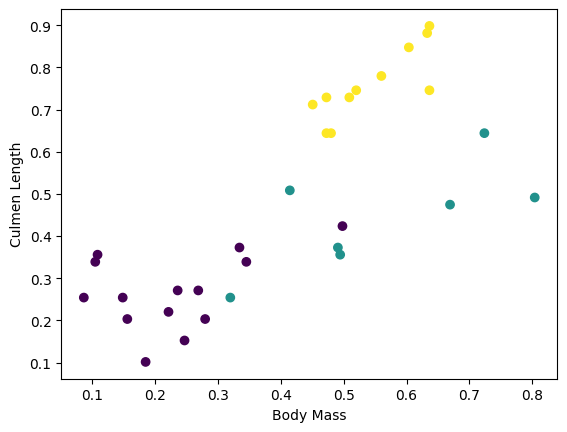

In [ ]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

In [ ]:

model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.04994418,  0.066384  , -0.15216234],
       [ 0.1650625 ,  0.05865037, -0.05591889],
       [-0.02132599,  0.09620228, -0.20838441],
       [-0.07608592,  0.05702172, -0.11686973],
       [-0.12459884,  0.043745  , -0.0724478 ]], dtype=float32)>

In [ ]:

tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.33044776, 0.3712133 , 0.298339  ],
       [0.37026262, 0.3328861 , 0.29685125],
       [0.3385116 , 0.3807285 , 0.2807599 ],
       [0.32233012, 0.3682212 , 0.30944872],
       [0.30893964, 0.3655817 , 0.32547867]], dtype=float32)>

In [ ]:

print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))


Loss test: 1.1672557592391968


In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables

In [ ]:
ptimizer = tf.keras.optimizers.SGD(learning_rate=0.01)





loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

In [ ]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


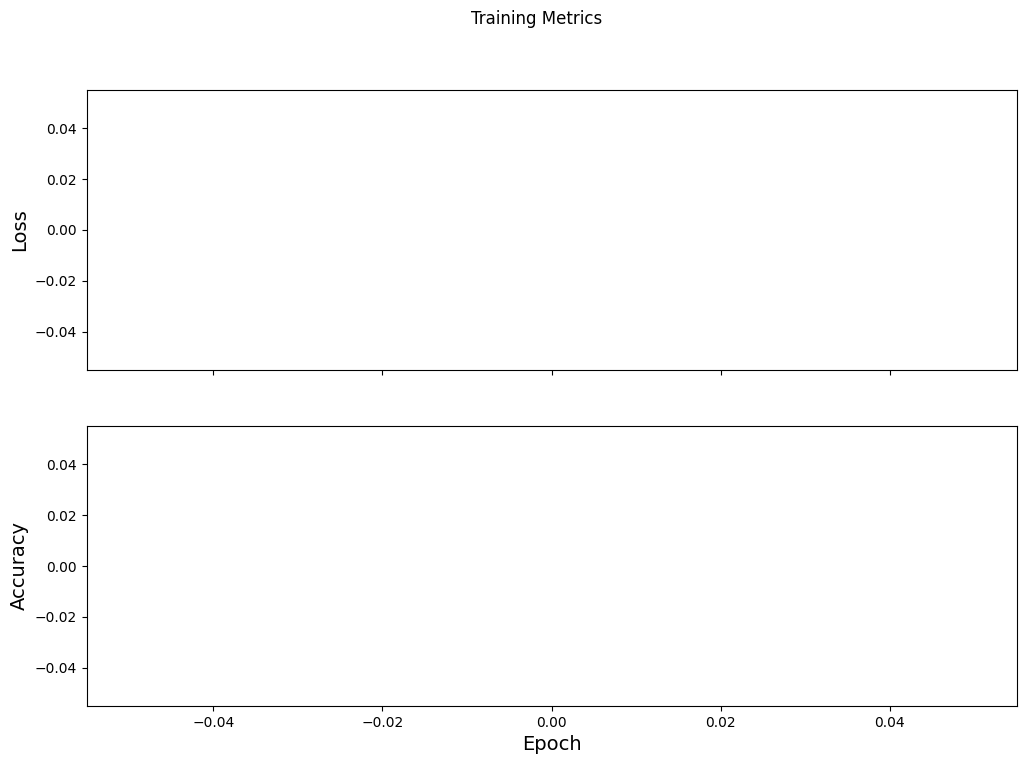

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 19.403%


In [ ]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 1],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 0],
       [0, 1]])>

In [ ]:

predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Chinstrap (37.3%)
Example 1 prediction: Adélie (37.8%)
Example 2 prediction: Chinstrap (37.5%)


**Distributed training with Keras**

In [ ]:

import tensorflow_datasets as tfds
import tensorflow as tf

import os

# Load the TensorBoard notebook extension.
%load_ext tensorboard


print(tf.__version__)

2.17.1


In [ ]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.PCX9VE_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.PCX9VE_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
strategy = tf.distribute.MirroredStrategy()


print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
#Define a function that normalizes the image pixel values from the [0, 255] range to the [0, 1] range (feature scaling):



def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label
#Apply this scale function to the training and test data, and then use the tf.data.Dataset APIs to shuffle the training data (Dataset.shuffle), and batch it (Dataset.batch). Notice that you are also keeping an in-memory cache of the training data to improve performance (Dataset.cache).



train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)#

In [ ]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

path = 'my_model.keras'


model.save(path)




unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

eval_loss, eval_acc = unreplicated_model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))




with strategy.scope():
  replicated_model = tf.keras.models.load_model(path)
  replicated_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

  eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
  print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1258 - loss: 2.3052
Eval loss: 2.305624008178711, Eval Accuracy: 0.12070000171661377
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1258 - loss: 2.3052
Eval loss: 2.305624008178711, Eval Accuracy: 0.12070000171661377


**Distributed training with DTensors**

In [ ]:
!pip install --quiet --upgrade tensorflow-datasets

In [ ]:

import tempfile
import numpy as np
import tensorflow_datasets as tfds

import tensorflow as tf

from tensorflow.experimental import dtensor

print('TensorFlow version:', tf.__version__)




TensorFlow version: 2.17.1


In [ ]:
train_data = tfds.load('imdb_reviews', split='train', shuffle_files=True, batch_size=64)
train_data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.G8SJQ8_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.G8SJQ8_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.G8SJQ8_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


<_PrefetchDataset element_spec={'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>

In [ ]:

text_vectorization = tf.keras.layers.TextVectorization(output_mode='tf_idf', max_tokens=1200, output_sequence_length=None)
text_vectorization.adapt(data=train_data.map(lambda x: x['text']))


def vectorize(features):
  return text_vectorization(features['text']), features['label']

train_data_vec = train_data.map(vectorize)
train_data_vec

<_MapDataset element_spec=(TensorSpec(shape=(None, 1200), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
class Dense(tf.Module):

  def __init__(self, input_size, output_size,
               init_seed, weight_layout, activation=None):
    super().__init__()

    random_normal_initializer = tf.function(tf.random.stateless_normal)

    self.weight = dtensor.DVariable(
        dtensor.call_with_layout(
            random_normal_initializer, weight_layout,
            shape=[input_size, output_size],
            seed=init_seed
            ))
    if activation is None:
      activation = lambda x:x
    self.activation = activation

    # bias is sharded the same way as the last axis of weight.
    bias_layout = weight_layout.delete([0])

    self.bias = dtensor.DVariable(
        dtensor.call_with_layout(tf.zeros, bias_layout, [output_size]))

  def __call__(self, x):
    y = tf.matmul(x, self.weight) + self.bias
    y = self.activation(y)

    return y

In [ ]:
class BatchNorm(tf.Module):

  def __init__(self):
    super().__init__()

  def __call__(self, x, training=True):
    if not training:
      # This branch is not used in the Tutorial.
      pass
    mean, variance = tf.nn.moments(x, axes=[0])
    return tf.nn.batch_normalization(x, mean, variance, 0.0, 1.0, 1e-5)





def make_keras_bn(bn_layout):
  return tf.keras.layers.BatchNormalization(gamma_layout=bn_layout,
                                            beta_layout=bn_layout,
                                            moving_mean_layout=bn_layout,
                                            moving_variance_layout=bn_layout,
                                            fused=False)

In [ ]:
mesh = dtensor.create_mesh([("batch", 8)], devices=DEVICES)

model = MLP([dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh),
             dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh),])

In [ ]:
def repack_batch(x, y, mesh):
  x = repack_local_tensor(x, layout=dtensor.Layout(['batch', dtensor.UNSHARDED], mesh))
  y = repack_local_tensor(y, layout=dtensor.Layout(['batch'], mesh))
  return x, y

sample_x, sample_y = train_data_vec.take(1).get_single_element()
sample_x, sample_y = repack_batch(sample_x, sample_y, mesh)

print('x', sample_x[:, 0])
print('y', sample_y)

In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.experimental import dtensor


def configure_virtual_cpus(ncpu):
  phy_devices = tf.config.list_physical_devices('CPU')
  tf.config.set_logical_device_configuration(
        phy_devices[0],
        [tf.config.LogicalDeviceConfiguration()] * ncpu)

configure_virtual_cpus(8)
tf.config.list_logical_devices('CPU')

devices = [f'CPU:{i}' for i in range(8)]

In [ ]:
tf.keras.backend.experimental.enable_tf_random_generator()
tf.keras.utils.set_random_seed(1337)

In [ ]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,
                        activation='relu',
                        name='d1',
                        kernel_layout=unsharded_layout_2d,
                        bias_layout=unsharded_layout_1d),
  tf.keras.layers.Dense(10,
                        name='d2',
                        kernel_layout=unsharded_layout_2d,
                        bias_layout=unsharded_layout_1d)
])

In [ ]:
ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


batch_size = 128

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
optimizer = tf.keras.dtensor.experimental.optimizers.Adam(0.01, mesh=mesh)
metrics = {'accuracy': tf.keras.metrics.SparseCategoricalAccuracy(mesh=mesh)}
eval_metrics = {'eval_accuracy': tf.keras.metrics.SparseCategoricalAccuracy(mesh=mesh)}

In [ ]:
num_epochs = 3

image_layout = dtensor.Layout.batch_sharded(mesh, 'batch', rank=4)
label_layout = dtensor.Layout.batch_sharded(mesh, 'batch', rank=1)

for epoch in range(num_epochs):
  print("============================")
  print("Epoch: ", epoch)
  for metric in metrics.values():
    metric.reset_state()
  step = 0
  results = {}
  pbar = tf.keras.utils.Progbar(target=None, stateful_metrics=[])
  for input in ds_train:
    images, labels = input[0], input[1]
    images, labels = pack_dtensor_inputs(
        images, labels, image_layout, label_layout)

    results.update(train_step(model, images, labels, optimizer, metrics))
    for metric_name, metric in metrics.items():
      results[metric_name] = metric.result()

    pbar.update(step, values=results.items(), finalize=False)
    step += 1
  pbar.update(step, values=results.items(), finalize=True)

  for metric in eval_metrics.values():
    metric.reset_state()
  for input in ds_test:
    images, labels = input[0], input[1]
    images, labels = pack_dtensor_inputs(
        images, labels, image_layout, label_layout)
    results.update(eval_step(model, images, labels, eval_metrics))

  for metric_name, metric in eval_metrics.items():
    results[metric_name] = metric.result()

  for metric_name, metric in results.items():
    print(f"{metric_name}: {metric.numpy()}")

In [ ]:

layout_map = tf.keras.dtensor.experimental.LayoutMap(mesh=mesh)

layout_map['feature.*kernel'] = dtensor.Layout.batch_sharded(mesh, 'batch', rank=2)
layout_map['feature.*bias'] = dtensor.Layout.batch_sharded(mesh, 'batch', rank=1)


with layout_map.scope():
  inputs = tf.keras.Input((16,), batch_size=16)
  x = tf.keras.layers.Dense(16, name='feature')(inputs)
  x = tf.keras.layers.Dropout(0.1)(x)
  output = tf.keras.layers.Dense(32, name='feature_2')(x)
  model = tf.keras.Model(inputs, output)

print(model.layers[1].kernel.layout)


with layout_map.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, name='feature', input_shape=(16,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(32, name='feature_2')
  ])

print(model.layers[2].kernel.layout)

Custom training with tf.distribute.**Strategy**

In [ ]:

# Import TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import os

print(tf.__version__)

2.17.1


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add a dimension to the array -> new shape == (28, 28, 1)
# This is done because the first layer in our model is a convolutional
# layer and it requires a 4D input (batch_size, height, width, channels).
# batch_size dimension will be added later on.
train_images = train_images[..., None]
test_images = test_images[..., None]

# Scale the images to the [0, 1] range.
train_images = train_images / np.float32(255)
test_images = test_images / np.float32(255)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# If the list of devices is not specified in
# `tf.distribute.MirroredStrategy` constructor, they will be auto-detected.
strategy = tf.distribute.MirroredStrategy()


print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:

BUFFER_SIZE = len(train_images)

BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 10




train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE)

train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

In [ ]:
def create_model():
  regularizer = tf.keras.regularizers.L2(1e-5)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3,
                             activation='relu',
                             kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3,
                             activation='relu',
                             kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64,
                            activation='relu',
                            kernel_regularizer=regularizer),
      tf.keras.layers.Dense(10, kernel_regularizer=regularizer)
    ])

  return model

In [ ]:
with strategy.scope():
  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

In [ ]:

with strategy.scope():
  model = create_model()

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)


def train_step(inputs):
  images, labels = inputs

  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = compute_loss(labels, predictions, model.losses)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_accuracy.update_state(labels, predictions)
  return loss

def test_step(inputs):
  images, labels = inputs

  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss.update_state(t_loss)
  test_accuracy.update_state(labels, predictions)


# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

@tf.function
def distributed_test_step(dataset_inputs):
  return strategy.run(test_step, args=(dataset_inputs,))

for epoch in range(EPOCHS):
  # TRAIN LOOP
  total_loss = 0.0
  num_batches = 0
  for x in train_dist_dataset:
    total_loss += distributed_train_step(x)
    num_batches += 1
  train_loss = total_loss / num_batches

  # TEST LOOP
  for x in test_dist_dataset:
    distributed_test_step(x)

  if epoch % 2 == 0:
    checkpoint.save(checkpoint_prefix)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, "
              "Test Accuracy: {}")
  print(template.format(epoch + 1, train_loss,
                         train_accuracy.result() * 100, test_loss.result(),
                         test_accuracy.result() * 100))

  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

In [ ]:
for _ in range(EPOCHS):
  total_loss = 0.0
  num_batches = 0
  train_iter = iter(train_dist_dataset)

  for _ in range(10):
    total_loss += distributed_train_step(next(train_iter))
    num_batches += 1
  average_train_loss = total_loss / num_batches

  template = ("Epoch {}, Loss: {}, Accuracy: {}")
  print(template.format(epoch + 1, average_train_loss, train_accuracy.result() * 100))
  train_accuracy.reset_states()

Multi-worker training with Keras

In [ ]:
import json
import os
import sys

In [ ]:

!pip install tf-nightly




import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.5/642.5 MB 847.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.5 MB/s eta 0:00:00


In [ ]:
%%writefile mnist_setup.py

import os
import tensorflow as tf
import numpy as np

def mnist_dataset(batch_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # The `x` arrays are in uint8 and have values in the [0, 255] range.
  # You need to convert them to float32 with values in the [0, 1] range.
  x_train = x_train / np.float32(255)
  y_train = y_train.astype(np.int64)
  train_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, y_train)).shuffle(60000).repeat().batch(batch_size)
  return train_dataset

def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28, 28)),
      tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      metrics=['accuracy'])
  return model

Writing mnist_setup.py


In [ ]:

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

In [ ]:

json.dumps(tf_config)


'{"cluster": {"worker": ["localhost:12345", "localhost:23456"]}, "task": {"type": "worker", "index": 0}}'

In [ ]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

In [ ]:
with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()

In [ ]:

%%writefile main.py

import os
import json

import tensorflow as tf
import mnist_setup

per_worker_batch_size = 64
tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])

strategy = tf.distribute.MultiWorkerMirroredStrategy()

global_batch_size = per_worker_batch_size * num_workers
multi_worker_dataset = mnist_setup.mnist_dataset(global_batch_size)

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()


multi_worker_model.fit(multi_worker_dataset, epochs=3, steps_per_epoch=70)
In the code snippet above note that the global_batch_size, which gets passed to Dataset.batch, is set to per_worker_batch_size * num_workers. This ensures that each worker processes batches of per_worker_batch_size examples regardless of the number of workers.

The current directory now contains both Python files:



ls *.py
Serialize the TF_CONFIG to JSON and add it to the environment variables:



os.environ['TF_CONFIG'] = json.dumps(tf_config)
Now, you can launch a worker process that will run the main.py and use the TF_CONFIG:



# first kill any previous runs
%killbgscripts


python main.py &> job_0.log


Custom training loop with Keras and MultiWorkerMirroredStrategy

In [ ]:

import json
import os
import sys

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:

os.environ.pop('TF_CONFIG', None)

In [ ]:

if '.' not in sys.path:
  sys.path.insert(0, '.')



import tensorflow as tf

In [ ]:
%%writefile mnist.py

import os
import tensorflow as tf
import numpy as np

def mnist_dataset(batch_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # The `x` arrays are in uint8 and have values in the range [0, 255].
  # You need to convert them to float32 with values in the range [0, 1]
  x_train = x_train / np.float32(255)
  y_train = y_train.astype(np.int64)
  train_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, y_train)).shuffle(60000)
  return train_dataset

def dataset_fn(global_batch_size, input_context):
  batch_size = input_context.get_per_replica_batch_size(global_batch_size)
  dataset = mnist_dataset(batch_size)
  dataset = dataset.shard(input_context.num_input_pipelines,
                          input_context.input_pipeline_id)
  dataset = dataset.batch(batch_size)
  return dataset

def build_cnn_model():
  regularizer = tf.keras.regularizers.L2(1e-5)
  return tf.keras.Sequential([
      tf.keras.Input(shape=(28, 28)),
      tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(32, 3,
                             activation='relu',
                             kernel_regularizer=regularizer),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,
                            activation='relu',
                            kernel_regularizer=regularizer),
      tf.keras.layers.Dense(10, kernel_regularizer=regularizer)
  ])

Writing mnist.py


Save and load a model using a distribution strategy

In [ ]:
import tensorflow_datasets as tfds

import tensorflow as tf

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()

def get_data():
  datasets = tfds.load(name='mnist', as_supervised=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  BUFFER_SIZE = 10000

  BATCH_SIZE_PER_REPLICA = 64
  BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

  train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

  return train_dataset, eval_dataset

def get_model():
  with mirrored_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.metrics.SparseCategoricalAccuracy()])
    return model


model = get_model()
train_dataset, eval_dataset = get_data()
model.fit(train_dataset, epochs=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 0.3970 - sparse_categorical_accuracy: 0.8811
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 0.0731 - sparse_categorical_accuracy: 0.9791


In [ ]:

keras_model_path = '/tmp/keras_save.keras'
model.save(keras_model_path)




restored_keras_model = tf.keras.models.load_model(keras_model_path)
restored_keras_model.fit(train_dataset, epochs=2)

Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9854
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9891


In [ ]:
another_strategy = tf.distribute.OneDeviceStrategy('/cpu:0')
with another_strategy.scope():
  restored_keras_model_ds = tf.keras.models.load_model(keras_model_path)
  restored_keras_model_ds.fit(train_dataset, epochs=2)

Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - loss: 0.0498 - sparse_categorical_accuracy: 0.9854
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9885


In [ ]:
model = get_model()  # get a fresh model
saved_model_path = '/tmp/tf_save'
tf.saved_model.save(model, saved_model_path)

In [ ]:
DEFAULT_FUNCTION_KEY = 'serving_default'
loaded = tf.saved_model.load(saved_model_path)
inference_func = loaded.signatures[DEFAULT_FUNCTION_KEY]

In [ ]:
predict_dataset = eval_dataset.map(lambda image, label: image)
for batch in predict_dataset.take(1):
  print(inference_func(batch))

{'output_0': <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[ 1.62827596e-01,  1.92602538e-02, -6.41826391e-02,
         1.87054127e-02, -1.58778336e-02, -9.08627454e-03,
         1.00490257e-01, -1.00904502e-01, -7.31920004e-02,
         1.13438584e-01],
       [ 1.88425884e-01,  9.03017297e-02, -9.61540267e-02,
        -1.00343227e-01, -7.62111172e-02,  2.75960118e-02,
         6.63774163e-02, -3.79546508e-02, -6.52953461e-02,
         1.75873712e-01],
       [ 5.48176877e-02,  6.21080697e-02, -1.41104301e-02,
         4.45145965e-02,  4.50072028e-02,  8.14840272e-02,
        -5.66420928e-02,  3.25238123e-03, -1.52668148e-01,
         2.10258886e-01],
       [ 1.49098039e-01,  3.94632779e-02, -8.98105558e-03,
        -5.88942952e-02,  7.18712211e-02,  1.13902083e-02,
        -1.66557764e-03, -3.53703238e-02, -1.68663040e-02,
         1.66853592e-01],
       [ 1.22613244e-01, -2.41539185e-03, -7.33592315e-04,
         7.40956143e-02,  8.10046047e-02,  8.93996039e-04,
       

In [ ]:
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)
  inference_func = loaded.signatures[DEFAULT_FUNCTION_KEY]

  dist_predict_dataset = another_strategy.experimental_distribute_dataset(
      predict_dataset)

  # Calling the function in a distributed manner
  for batch in dist_predict_dataset:
    result = another_strategy.run(inference_func, args=(batch,))
    print(result)
    break

{'output_0': <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[ 1.62827596e-01,  1.92602538e-02, -6.41826391e-02,
         1.87054127e-02, -1.58778336e-02, -9.08627454e-03,
         1.00490257e-01, -1.00904502e-01, -7.31920004e-02,
         1.13438584e-01],
       [ 1.88425884e-01,  9.03017297e-02, -9.61540267e-02,
        -1.00343227e-01, -7.62111172e-02,  2.75960118e-02,
         6.63774163e-02, -3.79546508e-02, -6.52953461e-02,
         1.75873712e-01],
       [ 5.48176877e-02,  6.21080697e-02, -1.41104301e-02,
         4.45145965e-02,  4.50072028e-02,  8.14840272e-02,
        -5.66420928e-02,  3.25238123e-03, -1.52668148e-01,
         2.10258886e-01],
       [ 1.49098039e-01,  3.94632779e-02, -8.98105558e-03,
        -5.88942952e-02,  7.18712211e-02,  1.13902083e-02,
        -1.66557764e-03, -3.53703238e-02, -1.68663040e-02,
         1.66853592e-01],
       [ 1.22613244e-01, -2.41539185e-03, -7.33592315e-04,
         7.40956143e-02,  8.10046047e-02,  8.93996039e-04,
       

In [ ]:
import tensorflow_hub as hub

def build_model(loaded):
  x = tf.keras.layers.Input(shape=(28, 28, 1), name='input_x')
  # Wrap what's loaded to a KerasLayer
  keras_layer = hub.KerasLayer(loaded, trainable=True)(x)
  model = tf.keras.Model(x, keras_layer)
  return model

another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)
  model = build_model(loaded)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  model.fit(train_dataset, epochs=2)

In [ ]:
model = get_model()

# Saving the model using Keras `Model.save`
model.save(saved_model_path)

another_strategy = tf.distribute.MirroredStrategy()
# Loading the model using the lower-level API
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)

In [ ]:

model = get_model()

# Saving the model to a path on localhost.
saved_model_path = '/tmp/tf_save'
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save(saved_model_path, options=save_options)

# Loading the model from a path on localhost.
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  loaded = tf.keras.models.load_model(saved_model_path, options=load_options)

In [ ]:
tf.saved_model.save(my_model, saved_model_path)
x = tf.saved_model.load(saved_model_path)
x.signatures

In [ ]:
BATCH_SIZE_PER_REPLICA = 4
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

dataset_size = 100
dataset = tf.data.Dataset.from_tensors(
    (tf.range(5, dtype=tf.float32), tf.range(5, dtype=tf.float32))
    ).repeat(dataset_size).batch(BATCH_SIZE)

my_model.compile(optimizer='adam', loss='mean_squared_error')
my_model.fit(dataset, epochs=2)

print(my_model.save_spec() is None)
my_model.save(saved_model_path)

Distributed datasets

In [ ]:
!import tensorflow as tf

# Helper libraries
import numpy as np
import os

print(tf.__version__)


/bin/bash: line 1: import: command not found
2.17.1


In [ ]:
# Simulate multiple CPUs with virtual devices
N_VIRTUAL_DEVICES = 2
physical_devices = tf.config.list_physical_devices("CPU")
tf.config.set_logical_device_configuration(
    physical_devices[0], [tf.config.LogicalDeviceConfiguration() for _ in range(N_VIRTUAL_DEVICES)])

In [ ]:
print("Available devices:")
for i, device in enumerate(tf.config.list_logical_devices()):
  print("%d) %s" % (i, device))

Available devices:
0) LogicalDevice(name='/device:CPU:0', device_type='CPU')


In [ ]:
global_batch_size = 16
# Create a tf.data.Dataset object.
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(global_batch_size)

@tf.function
def train_step(inputs):
  features, labels = inputs
  return labels - 0.3 * features

# Iterate over the dataset using the for..in construct.
for inputs in dataset:
  print(train_step(inputs))

tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[0.7]
 [0.7]
 [0.7]
 [0.7]], shape=(4, 1), dtype=float32)


In [ ]:
global_batch_size = 16
mirrored_strategy = tf.distribute.MirroredStrategy()

dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(global_batch_size)
# Distribute input using the `experimental_distribute_dataset`.
dist_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)
# 1 global batch of data fed to the model in 1 step.
print(next(iter(dist_dataset)))

(<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>, <tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>)


In [ ]:
tf.data.Dataset.range(6).batch(4, drop_remainder=False)

<_BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [ ]:
tf.data.Dataset.range(4).batch(4)

<_BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [ ]:

dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(64).batch(16)
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
dataset = dataset.with_options(options)

In [ ]:

mirrored_strategy = tf.distribute.MirroredStrategy()

def dataset_fn(input_context):
  batch_size = input_context.get_per_replica_batch_size(global_batch_size)
  dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(64).batch(16)
  dataset = dataset.shard(
      input_context.num_input_pipelines, input_context.input_pipeline_id)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(2)  # This prefetches 2 batches per device.
  return dataset

dist_dataset = mirrored_strategy.distribute_datasets_from_function(dataset_fn)

In [ ]:
global_batch_size = 16
epochs = 5
steps_per_epoch = 5
mirrored_strategy = tf.distribute.MirroredStrategy()

dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(global_batch_size)
dist_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)

@tf.function(input_signature=[dist_dataset.element_spec])
def train_step(per_replica_inputs):
  def step_fn(inputs):
    return 2 * inputs

  return mirrored_strategy.run(step_fn, args=(per_replica_inputs,))

for _ in range(epochs):
  iterator = iter(dist_dataset)
  for _ in range(steps_per_epoch):
    output = train_step(next(iterator))
    tf.print(output)

([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]])
([[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]], [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 